In [ ]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# make sure you add a shortcut of "295R-Caps-Pattern" folder to your own Drive if you're shared this folder
!ls "/content/drive/My Drive/295R-Caps-Pattern/Data"

raw  subsampled


In [ ]:
# input folders
data = "/content/drive/My Drive/295R-Caps-Pattern/Data"

## BEST SELLER RANK HISTORY DATA

FILE:  asin_bsr_history.csv

**OVERVIEW:** 

Amazon gives products on their platform a Best Seller Rank (BSR). Rank 1 in a category is the best selling product, 2 is second best etc. This data set is a history of best seller rank observations for Amazon products within the Vitamins and Dietary Supplements category. 
https://www.amazon.com/
Best-Sellers-Health-Personal-Care-Vitamins-Dietary-Supplements/zgbs/hpc/3764441

**COLUMNS:**

`DATE`: Date of the observation. Not all dates are represented. You may need to forward fill and backfill missing dates for the model that you build. 

`RANK`: This is the Amazon best seller rank. Each rank should be positive.

`AVG180_PRICE`: This is the average price of the product over the past 180 days.

`ASIN`: Similar to a sku or part number, Amazon gives each of their products a unique identifier called an ASIN. You can see any product by going to amazon.com/dp/{your asin here}


## ASIN REVIEW HISTORY DATA
FILE: asin_review_history.csv

**OVERVIEW:**
Amazon customers have the option to leave reviews for Amazon products (ASINs). This data set is a collection of amazon reviews for products within the Amazon Vitamins and Dietary Supplements category. 
https://www.amazon.com/Best-Sellers-Health-Personal-Care-Vitamins-Dietary-Supplements/zgbs/hpc/3764441

**COLUMNS:**

`ASIN`: Similar to a sku or part number, Amazon gives each of their products a unique identifier called an ASIN. You can see any product by going to amazon.com/dp/{your asin here}

`PRODUCT_NAME`: Product or ASIN title

`REVIEW_TITLE`: Title of the review

`REVIEW_RATING`: Rating from 1-5 starts 

`REVIEW_DATE`: Date the review was written

`REVIEWVOTES`: Number of people that found a review helpful. This can be null meaning nobody has found the review helpful. 

`REVIEW_VERIFIED_PURCHASE`: Boolean True or False if the review came from a customer who is verified to have purchased the product

`REVIEWCOMMENTCOUNT`: Ignore this column. It is always 0

`TEMP`: String before parsed to extract country name

`COUNTRY_NAME`: Name of country where review was left.


In [ ]:
bsr_full = pd.read_csv(f'{data}/raw/asin_bsr_history.csv')
review_full = pd.read_csv(f'{data}/raw/asin_review_history.csv')

In [ ]:
print("Full size of the BEST SELLER RANK HISTORY DATA:",len(bsr_full))
print("Full size of the ASIN REVIEW HISTORY DATA:",len(review_full))

Full size of the BEST SELLER RANK HISTORY DATA: 29090469
Full size of the ASIN REVIEW HISTORY DATA: 5532637


In [ ]:
# copy from lotus 
prod_asin_rev = review_full['asin'].unique()
prod_asin_bsr = bsr_full['asin'].unique()
print(len(prod_asin_rev), 'unique products in reviews')
print(len(prod_asin_bsr), 'unique products in bsr')

# get interset of the two dataset
prod_asin = list(set(prod_asin_rev).intersection(set(prod_asin_bsr)))
print(len(prod_asin), 'products in intersection')

9977 unique products in reviews
9991 unique products in bsr
9958 products in intersection


# BSR data

### check null value

In [ ]:
pd.isnull(bsr_full).sum()

Unnamed: 0           0
date                 0
rank                 0
avg180_price    209239
asin                 0
dtype: int64

In [ ]:
bsr_sorted = bsr_full.sort_values('date').reset_index()
bsr_sorted.drop(['index', 'Unnamed: 0'], axis=1, inplace=True)

In [ ]:
bsr_sorted.describe()

,rank,avg180_price
count,2.909047e+07,2.888123e+07
mean,4.131325e+04,2.544546e+01
std,8.896890e+04,2.067265e+01
min,1.000000e+00,1.990000e+00
25%,9.255714e+03,1.452000e+01
50%,2.109454e+04,2.029000e+01
75%,4.022000e+04,2.997000e+01
max,7.795632e+06,1.450000e+03


In [ ]:
bsr_group = bsr_full.groupby('asin').agg({'asin':'count', 'rank':'mean', 'avg180_price':'mean'}).sort_values('rank')
print('on avgerage, each product has {} records'.format(int(bsr_group['asin'].mean())))

on avgerage, each product has 2911 records


In [ ]:
# check the correlation between columns
print(bsr_group['rank'].corr(bsr_group['avg180_price']))
print('no obvious relationship between rank and avg180_price')

0.0936900778868188
no obvious relationship between rank and avg180_price


# Review data

In [ ]:
review_group = review_full.groupby('asin').agg({'asin':'count', 'reviewrating':'mean'}).sort_values('reviewrating', ascending=False)
print('on avgerage, each product has {} reviews'.format(int(review_group['asin'].mean())))
print('{:.4}% of the reviews have a title'.format(sum(review_full['review_title'].notna())/len(review_full)*100))


on avgerage, each product has 554 reviews


In [ ]:
print('{:.4}% of the reviews have a title'.format(sum(review_full['review_title'].notna())/len(review_full)*100))

99.98% of the reviews have a title


In [ ]:
# check number of asin in each country and the average rating
review_group2 = review_full.groupby('country_name').agg({'asin':'count', 'reviewrating':'mean'}).sort_values('reviewrating', ascending=False)

In [ ]:
review_group2

,asin,reviewrating
country_name,,
wed in Brazil,403,4.550868
wed in Italy,7775,4.422122
wed in Spain,7001,4.380374
United States,5410188,4.378240
United Kingdom,57192,4.370087
wed in Mexico,979,4.291113
wed in Canada,26338,4.243147
wed in Sweden,29,4.206897
wed in France,5310,4.182486


### check null value

In [ ]:
pd.isnull(review_full).sum()

Unnamed: 0                      0
asin                            0
product_name                    0
review_title                 1303
review_text                  1499
reviewrating                    0
review_date                     0
reviewvotes               3633882
reviewverifiedpurchase          0
reviewcommentcount              0
temp                            0
country_name                    0
dtype: int64

### check the relationship between reviewvotes_num and review_len 

In [ ]:
review_full['reviewvotes_num'] = review_full["reviewvotes"].fillna('0').str.split().str[0].replace('One','1').str.replace(',','').astype('int')
review_full['review_len'] = review_full['review_text'].fillna('0').apply(len)

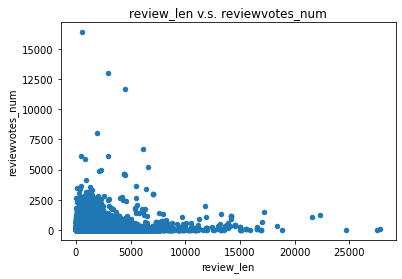

In [ ]:
review_full.plot('review_len','reviewvotes_num',kind='scatter',title='review_len vs. reviewvotes_num')

In [ ]:
print(review_full['review_len'].corr(review_full['reviewvotes_num']))
print("No obvious correlation between review length and review votes number")

0.19610549879840072
No obvious correlation between review length and review votes number


### compare verified purchase and not verified purchase

In [ ]:
review_sorted = review_full.sort_values('review_date').reset_index()
review_sorted.drop(['index', 'Unnamed: 0'], axis=1, inplace=True)

In [ ]:
perc_verified_purchase = len(review_sorted[review_sorted['reviewverifiedpurchase'] ==True])/len(review_sorted)
print('{:.4}% of reviews are verified purchase.'.format(perc_verified_purchase*100))

93.82% of reviews are verified purchase.


In [ ]:
review_verified = review_full[review_full['reviewverifiedpurchase'] ==True]
review_not_verified = review_full[review_full['reviewverifiedpurchase'] ==False]

In [ ]:
review_verified.describe()

,Unnamed: 0,reviewrating,reviewcommentcount,reviewvotes_num,review_len
count,5.190938e+06,5.190938e+06,5190938.0,5.190938e+06,5.190938e+06
mean,2.765424e+06,4.387259e+00,0.0,2.620007e+00,1.730230e+02
std,1.597125e+06,1.209719e+00,0.0,2.606821e+01,2.435018e+02
min,0.000000e+00,1.000000e+00,0.0,0.000000e+00,1.000000e+00
25%,1.382016e+06,4.000000e+00,0.0,0.000000e+00,4.300000e+01
50%,2.767578e+06,5.000000e+00,0.0,0.000000e+00,1.030000e+02
75%,4.147283e+06,5.000000e+00,0.0,1.000000e+00,2.140000e+02
max,5.532636e+06,5.000000e+00,0.0,1.636800e+04,2.785100e+04


In [ ]:
review_not_verified.describe()

,Unnamed: 0,reviewrating,reviewcommentcount,reviewvotes_num,review_len
count,3.416990e+05,341699.000000,341699.0,341699.000000,341699.000000
mean,2.779903e+06,4.208057,0.0,3.101730,358.228069
std,1.597221e+06,1.330268,0.0,26.866181,471.851266
min,2.944000e+03,1.000000,0.0,0.000000,1.000000
25%,1.407140e+06,4.000000,0.0,0.000000,92.000000
50%,2.747308e+06,5.000000,0.0,0.000000,221.000000
75%,4.184742e+06,5.000000,0.0,1.000000,455.000000
max,5.532590e+06,5.000000,0.0,3150.000000,24686.000000
